You are going to read some data, take a look at it, smooth it, and think about
whether the objects you've found are real.

I've provided three python files:
-     detection.py  Some code to detect objects
-     imageProc.py	Some image processing code to get you started
-     utils.py		Convenience functions for a Data object, I/O, and image display

There are also some data files.  These started out as fits (as read with pyfits.py, not provided) but
I saved them as numpy ".npy" files (to be read with numpy.load).

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

%matplotlib inline
# notebook

In [2]:
import detection
import imageProc
import utils

Let's take a look at some data.  

Rather than asking you to install a display tool such as ds9, ginga, firefly, or aladin I've provided you with a lightweight image display tool, utils.mtv()

The coloured overlay shows the mask bits that tells you which pixels are bad (its visibility is controlled
by the alpha parameter).  The stretch is controlled by "b" (it's roughly the transition from a linear to a
logarithmic stretch).

You can print the value of pixel (x, y) with
    print da.image[y, x]
(note the order of the indices).  Here x and y can be scalars or numpy arrays

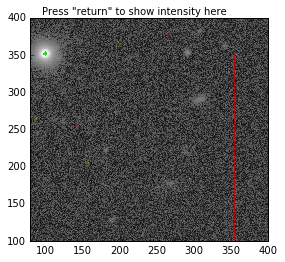

In [3]:
da = utils.Data()
da.read()

utils.mtv(da, b=10, alpha=0.8)
xlim, ylim = (80, 400), (100, 400)

plt.xlim(xlim); plt.ylim(ylim)
plt.show()

We can show the same data without marking the bad pixels -- you'll see that I fixed them. Magic

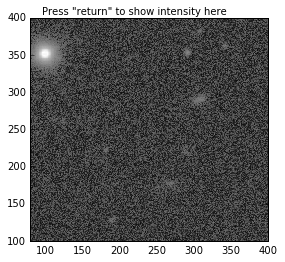

In [4]:
utils.mtv(da, b=10, alpha=0.0, fig=2)
plt.xlim(xlim); plt.ylim(ylim)
plt.show()

If you want to look at the raw data, you can:

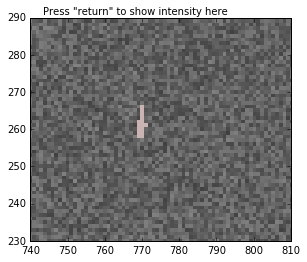

In [5]:
raw = utils.Data()
raw.read(readRaw=True)

utils.mtv(raw, b=10, alpha=0.3)
plt.xlim(740, 810); plt.ylim(230, 290)
plt.show()

Next write a function to smooth the data with a Gaussian filter.  You can do the work with ```convolveWithGaussian``` in the next cell.

_N.b._ You can make a copy of a ```Data``` object using ```da.copy()```

In [6]:
def gaussian2D(beta):
    size = int(3*abs(beta) + 1)
    x, y = np.mgrid[-size:size+1, -size:size+1]
    phi = np.exp(-(x**2 + y**2)/(2*beta**2))
    phi /= phi.sum()

    return phi

def convolveWithGaussian(image, beta):
    phi = gaussian2D(beta)

    return scipy.signal.convolve(image, phi, mode='same')

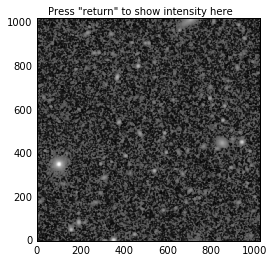

In [7]:
# %%timeit -n 1 -r 1

sda = da.copy()
beta = 2.5
sda.image = convolveWithGaussian(sda.image, beta)

utils.mtv(sda.image)

We can also calculate the filter's _effective area_ (and confirm or deny that I did my Gaussian integrals correctly in the lecture)

In [8]:
phi = gaussian2D(beta)
n_eff = 1/np.sum(phi**2)
print "n_eff = %.3f (analytically: %.3f)" % (n_eff, 4*pi*beta**2)

n_eff = 78.345 (analytically: 78.540)


That convolution seemed slow to me.  Go back to the cell, uncomment the ```%%timeit``` line, and run it again.  How long did it take?

OK, take a look at the next cell and see if you can see what I did -- it's more python (and loops too) so it must be slower.  Is it?

In [9]:
def convolveWithGaussian(image, beta):
    def gaussian1D(beta):
        size = int(3*abs(beta) + 1)
        x = np.arange(-size, size+1)
        phi = np.exp(-x**2/(2*beta**2))
        phi /= phi.sum()

        return phi

    beta = 2.5
    phi = gaussian1D(beta)

    for y in range(0, image.shape[0]):
        image[y] = scipy.signal.convolve(image[y], phi, mode='same')
    for x in range(0, image.shape[1]):
        image[:, x] = scipy.signal.convolve(image[:, x], phi, mode='same')
        
    return image

Now let's look for objects.  We know how to do this;  we smooth the image with the PSF then look for peaks.  It's not totally trivial to find all the sets of connected pixels, so I provided you with a function ```detection.findObjects``` to do the work

In [10]:
nsigma = 3.5
threshold = nsigma*sqrt(np.median(sda.variance)/n_eff)
footprints = detection.findObjects(sda.image, threshold, grow=3)

print "I found %d objects" % (len(footprints))

I found 259 objects


We can look at all our objects by looping over the footprints:

In [11]:
nShow = 10
for foot in footprints.values()[0:nShow]:
    print "(%5d, %5d) %3d" % (foot.centroid[0], foot.centroid[1], foot.npix)
if len(footprints) > nShow:
    print "..."

(   97,     7)  63
(  313,     9) 252
(  351,    20) 675
(  698,     6)  56
(  731,    15) 296
(  826,     8)  73
(  977,    30) 262
(  960,    27)  68
(  450,    40) 408
(  910,    21)  29
...


Or by setting a mask plane -- this way we'll be able to see all the pixels

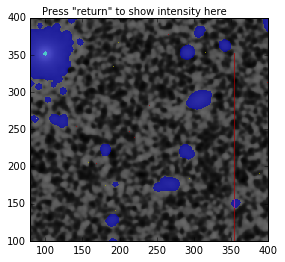

In [12]:
sda.clearMaskPlane("DETECTED")
detection.setMaskFromFootprints(sda, footprints, "DETECTED")

utils.mtv(sda)

plt.xlim(xlim); plt.ylim(ylim)
plt.show()

We can do the same thing for the original (unsmoothed) image

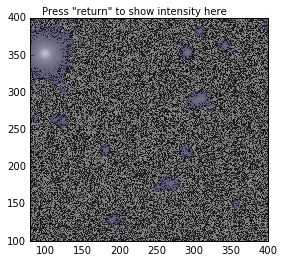

In [13]:
da.clearMaskPlane("DETECTED")
detection.setMaskFromFootprints(da, footprints, "DETECTED")

utils.mtv(da, alpha=0.3)
plt.xlim(xlim); plt.ylim(ylim)
plt.show()

I lied to you; or at least I didn't tell you everything.  That 'data' was actually the output from the LSST simulator, which means that I know the Truth;  more accurately, I know the location of every photon that arrived from the sources without any sky background. The pixels are 0.2 arcseconds on a side.

Let's overlay the detection mask on the truth.

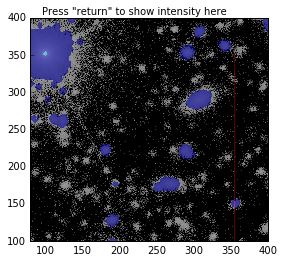

In [14]:
t = utils.Data(image=da.truth, mask=sda.mask)
utils.mtv(t, I0=1, b=0.01, alpha=0.6)
plt.xlim(xlim); plt.ylim(ylim)
plt.show()

If you look at the direct image you can see things that seem real when you compare with the truth, for example the object at (156, 205).  So should we be using a lower threshold?  What happens if you choose a smaller value?

OK, so that picked up the object I pointed out, but it picked up some noise too.  How many false objects would I expect to detect per square degree?  Naïvely we'd expect each PSF-sized patch to be independent, so we can try using the tails of a Gaussian to estimate how many objects we'd detect per square degree.  If I take the area of a PSF to be 0.5 arcsec^2, I have

In [15]:
import scipy.special

pixelSize = 0.200

nPerPsf = 0.5*scipy.special.erfc(nsigma/sqrt(2))
nPerDeg = nPerPsf*3600**2/0.5

print "False positives per degree: %d  In data: %d" % (
    nPerDeg, nPerDeg/(3600/(da.image.shape[0]*pixelSize))**2)

False positives per degree: 6029  In data: 19


Nick Kaiser has done the theory more carefully (it was easy for him;  he used results from a classic paper, Bardeen et. al, of which he was a co-author). The answer is that the number of peaks per-arcsecond is
$$
\frac{1}{2^{5/2} \pi^{3/2} \beta^2} n_\sigma e^{-n_\sigma^2/2}
$$

I'm not as clever as Nick, but I do have access to a computer...

Gaussian 5 32 18.6


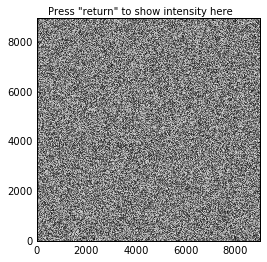

In [16]:
# %%timeit -n 1 -r 1

detection = reload(detection)

ndeg = 1.0/2.0                       # Size of image we'll simulate (in degrees)
size = int(3600*ndeg/pixelSize)      # Size of image we'll simulate (in pixels)
im = np.zeros((size, size))

nsigma, Poisson= 5, False
np.random.seed(667)
sigma = 10
if Poisson:
    mu = sigma**2
    im += np.random.poisson(lam=mu, size=size*size).reshape(size, size) - mu
else:
    im += np.random.normal(scale=sigma, size=size*size).reshape(size, size)

sim = convolveWithGaussian(im, beta)
n_eff = 4*pi*beta**2   # Effective area of PSF

threshold = nsigma*sigma/sqrt(n_eff)
footprints = detection.findObjects(sim, threshold, grow=0)
print "%s %g %d %.1f" % (("Poisson" if Poisson else "Gaussian"), nsigma, \
                      len(footprints)/ndeg**2, \
                      3600**2*1/(2**2.5*pi**1.5*(beta*pixelSize)**2)*nsigma*exp(-nsigma**2/2))

if not False:    
    tmp = utils.Data(sim)
    tmp.clearMaskPlane("DETECTED")
    detection.setMaskFromFootprints(tmp, footprints, "DETECTED")

    utils.mtv(tmp, alpha=1)

By patiently running the previous cell several times, I arrived at:

    nsigma Gaussian Poisson Gaussian Prediction
    3      52288    55008   54848.1
    3.5    11888    13296   12600
    5      0        48      18.6
    5.5    2        16      2.4
    6      0        0       0.2